#Подключаем библиотеки

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape,Lambda
from six.moves import input
import os
import random
from keras.layers import concatenate
import pickle
from sklearn.model_selection import train_test_split
import cv2
import sys
import keras
import pandas as pd
import tarfile
from six.moves import input
import tqdm
from scipy.stats import norm
from scipy.stats import multivariate_normal
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from IPython.display import clear_output
from keras.models import Model
from keras.layers.convolutional import UpSampling2D, Conv2D
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/База картинок/kaggle.zip'

#Подготавливаем дата-сет

In [ ]:
def load_lfw_dataset(use_raw=False):
  Datadir = 'kaggle'
  catdog_set = os.listdir('kaggle')

  training_data = []
  categorical=[]

  for Category in catdog_set:
    path = os.path.join(Datadir, Category)
    classification = catdog_set.index(Category)
    for img in os.listdir(path):
      try:
        nameimg=path + '/'+ img
        img_array = cv2.imread(os.path.join(nameimg), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (128, 128))
        training_data.append(img_resize)
        if classification==0:
          class_cat=1
          class_dog=0
        elif classification==1:
          class_cat=0
          class_dog=1
        categorical.append([class_cat,class_dog])
      except Exception as e:
        pass

  training_data = np.stack(training_data).astype('uint8')
  categorical = pd.DataFrame(categorical)
  return training_data,categorical

In [ ]:
x,y = load_lfw_dataset(use_raw=True)
x = np.array(x)
y = np.array(y)

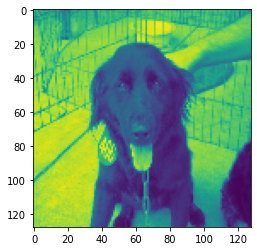

In [ ]:
plt.imshow(x[10])

In [ ]:
print(x.shape)
print(y.shape)

(24946, 128, 128)
(24946, 2)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.19823)
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 128, 128, 1))
x_test  = np.reshape(x_test,  (len(x_test),  128, 128, 1))

y_train_category, y_test_category = train_test_split(y,test_size=0.19823)
y_train_category = y_train_category.astype('float32')
y_test_category = y_test_category.astype('float32')
num_classes=y_test_category.shape[1]

In [ ]:
print(x_train.shape)
print(y_train.shape)

(20000, 128, 128, 1)
(20000, 2)


#Обучаем модель

In [ ]:
batch_size = 64
latent_dim = 100
dropout_rate = 0.3
start_lr = 0.0001

In [ ]:
def create_vae():
    models = {}

    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    input_img = Input(shape=(128, 128, 1))
    input_lbl = Input(shape=(num_classes,), dtype='float32')
    conv_img = Conv2D(4, (3,3), padding="same")(input_img)
    leaky_img=LeakyReLU(alpha=0.2)(conv_img)
    conv_img = Conv2D(4, (3,3), padding="same")(leaky_img)
    leaky_img=LeakyReLU(alpha=0.2)(conv_img)
    flatten_img = Flatten()(leaky_img)
    x = concatenate([flatten_img, input_lbl])
    x = Dense(2048, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = Dense(1024, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    encoded = Dense(latent_dim)(x)
    models["encoder"]  = keras.Model([input_img, input_lbl], encoded, name="encoder")

    z = Input(shape=(latent_dim,))
    input_lbl_d = Input(shape=(num_classes,), dtype='float32')
    x = concatenate([z, input_lbl_d])
    x=Dense(1024)(x)
    x=LeakyReLU()(x)
    x=apply_bn_and_dropout(x)
    x=Dense(2048)(x)
    x=LeakyReLU()(x)
    x=apply_bn_and_dropout(x)
    x = Dense(128*128, activation='sigmoid')(x)
    decoded = Reshape((128,128, 1))(x)
    models["decoder"]=keras.Model([z, input_lbl_d], decoded, name="decoder")

    models["autoencoder"] = keras.Model([input_img, input_lbl, input_lbl_d],models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), name="autoencoder")


    return models

models = create_vae()
autoencoder = models["autoencoder"]

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
autoencoder.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 100)          136437024   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2)]          0                                  

In [ ]:
autoencoder.fit([x_train, y_train_category, y_train_category],
                x_train, epochs=10,
        validation_data=([x_test, y_test_category, y_test_category],
                         x_test))

Epoch 1/10
625/625 [==============================] - 1237s 2s/step - loss: 0.0353 - val_loss: 0.0315
Epoch 2/10
625/625 [==============================] - 1245s 2s/step - loss: 0.0302 - val_loss: 0.0412
Epoch 3/10
625/625 [==============================] - 1250s 2s/step - loss: 0.0290 - val_loss: 0.0289
Epoch 4/10
625/625 [==============================] - 1259s 2s/step - loss: 0.0277 - val_loss: 0.0258
Epoch 5/10
625/625 [==============================] - 1265s 2s/step - loss: 0.0266 - val_loss: 0.0270
Epoch 6/10
625/625 [==============================] - 1262s 2s/step - loss: 0.0263 - val_loss: 0.0305
Epoch 7/10
625/625 [==============================] - 1260s 2s/step - loss: 0.0260 - val_loss: 0.0318
Epoch 8/10
625/625 [==============================] - 1261s 2s/step - loss: 0.0257 - val_loss: 0.0243
Epoch 9/10
625/625 [==============================] - 1253s 2s/step - loss: 0.0257 - val_loss: 0.0292
Epoch 10/10
625/625 [==============================] - 1252s 2s/step - loss: 0.025

#Результаты обучения

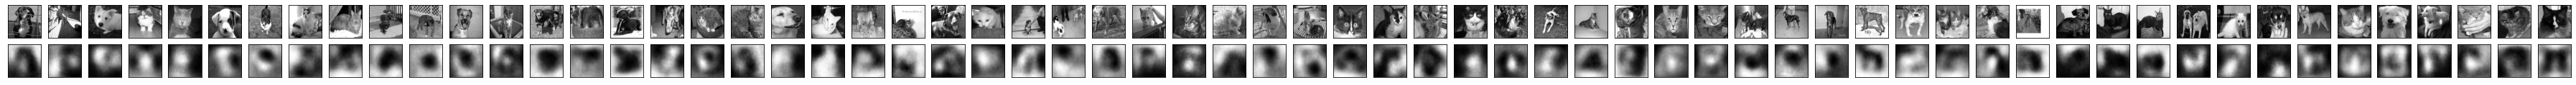

In [ ]:
n =64
j=10

imgs = x_test[:n]
imgs_lbls = y_test_category[:batch_size]
decoded_imgs = autoencoder.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)

plt.figure(figsize=(n, j))
for i in range(n):
  ax = plt.subplot(j, n , i + 1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax2 = plt.subplot(j, n, i + n + 1)
  plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
  ax2.get_xaxis().set_visible(False)
  ax2.get_yaxis().set_visible(False)

plt.show()